<a href="https://colab.research.google.com/github/El-47/Cs367/blob/master/Week5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install yfinance
!pip install pandas
!pip install numpy
!pip install hmmlearn
!pip install matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 1.5 MB/s eta 0:00:00


In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM

In [3]:
# Define the stock symbol and time period
ticker = 'AAPL'
start_date = '2014-01-01'
end_date = '2024-01-01'

# Download the historical data
data = yf.download(ticker, start=start_date, end=end_date)

# Display the first few rows of the dataset
data.head()


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,19.845715,19.893929,19.715000,19.754642,17.253256,234684800
2014-01-03,19.745001,19.775000,19.301071,19.320715,16.874273,392467600
2014-01-06,19.194643,19.528570,19.057142,19.426071,16.966299,412610800
2014-01-07,19.440001,19.498571,19.211430,19.287144,16.844950,317209200
2014-01-08,19.243214,19.484285,19.238930,19.409286,16.951632,258529600


In [8]:
# Extract the Adjusted Close price
data['Adj Close'] = data['Adj Close']

# Calculate the daily returns (percentage change)
data['Returns'] = data['Adj Close'].pct_change()

# Drop any rows with missing data
data = data.dropna()

# Display the preprocessed data
data[['Adj Close', 'Returns']].head()



,Adj Close,Returns
Date,,
2014-01-07,16.844950,-0.007152
2014-01-08,16.951632,0.006333
2014-01-09,16.735151,-0.012770
2014-01-10,16.623495,-0.006672
2014-01-13,16.710518,0.005235


In [9]:
# Reshape returns for the HMM model (HMM expects a 2D array)
returns = data['Returns'].values.reshape(-1, 1)


In [10]:
# Set the number of hidden states
n_hidden_states = 2  # You can change this value based on experimentation

# Initialize and fit the Gaussian HMM
model = GaussianHMM(n_components=n_hidden_states, covariance_type='full', n_iter=1000).fit(returns)

# Predict the hidden states
hidden_states = model.predict(returns)

# Display the transition matrix and means of the hidden states
print("Transition matrix:")
print(model.transmat_)

print("\nMeans and variances of each hidden state:")
for i in range(n_hidden_states):
    print(f"\nHidden State {i+1}:")
    print(f"Mean = {model.means_[i][0]}")
    print(f"Variance = {np.diag(model.covars_[i])[0]}")


Transition matrix:
[[0.90253766 0.09746234]
 [0.03401193 0.96598807]]

Means and variances of each hidden state:

Hidden State 1:
Mean = -0.0003269996911580884
Variance = 0.0008636246054433049

Hidden State 2:
Mean = 0.0016317962162923408
Variance = 0.00013956890214918073


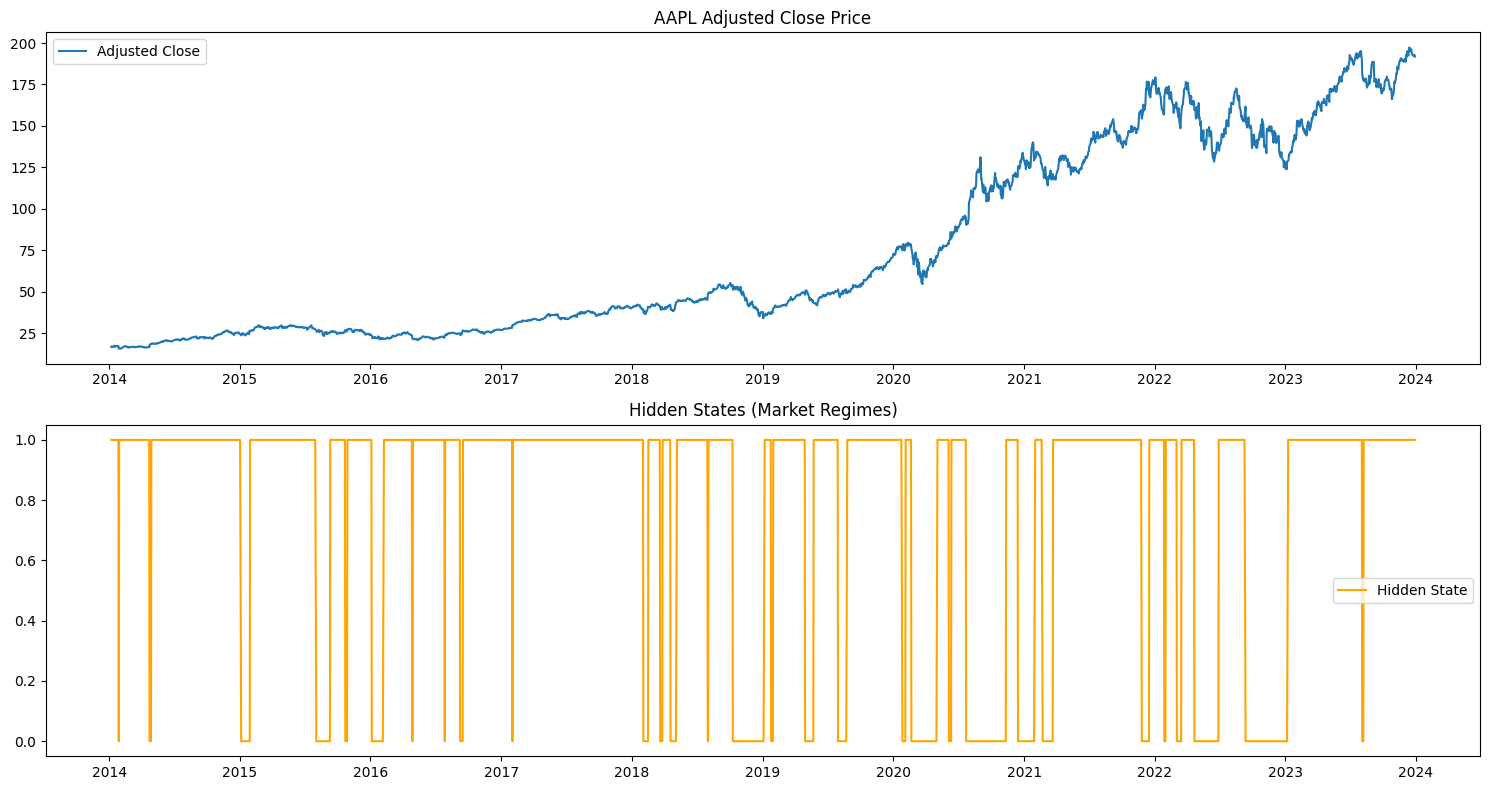

In [11]:
# Add the hidden states to the DataFrame for visualization
data['Hidden State'] = hidden_states

# Plot the Adjusted Close price and the hidden states
plt.figure(figsize=(15, 8))

# Plot Adjusted Close price
plt.subplot(2, 1, 1)
plt.plot(data.index, data['Adj Close'], label='Adjusted Close')
plt.title(f'{ticker} Adjusted Close Price')
plt.legend()

# Plot hidden states
plt.subplot(2, 1, 2)
plt.plot(data.index, data['Hidden State'], label='Hidden State', color='orange')
plt.title('Hidden States (Market Regimes)')
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
# Analyze the mean and variance of each hidden state
for i in range(n_hidden_states):
    print(f"Hidden State {i+1} Analysis:")
    print(f"Mean Return: {model.means_[i][0]}")
    print(f"Variance of Returns: {np.diag(model.covars_[i])[0]}")


Hidden State 1 Analysis:
Mean Return: -0.0003269996911580884
Variance of Returns: 0.0008636246054433049
Hidden State 2 Analysis:
Mean Return: 0.0016317962162923408
Variance of Returns: 0.00013956890214918073


In [13]:
# Map the hidden states to the corresponding dates in the data
hidden_states_dates = pd.DataFrame({'Date': data.index, 'Hidden State': hidden_states})

# Identify the periods corresponding to each hidden state
state_0_periods = hidden_states_dates[hidden_states_dates['Hidden State'] == 0]
state_1_periods = hidden_states_dates[hidden_states_dates['Hidden State'] == 1]

# Display the first few rows for each hidden state
print("Periods corresponding to Hidden State 0 (e.g., low volatility):")
print(state_0_periods.head())

print("\nPeriods corresponding to Hidden State 1 (e.g., high volatility):")
print(state_1_periods.head())


Periods corresponding to Hidden State 0 (e.g., low volatility):
          Date  Hidden State
14  2014-01-28             0
74  2014-04-24             0
75  2014-04-25             0
76  2014-04-28             0
250 2015-01-05             0

Periods corresponding to Hidden State 1 (e.g., high volatility):
        Date  Hidden State
0 2014-01-07             1
1 2014-01-08             1
2 2014-01-09             1
3 2014-01-10             1
4 2014-01-13             1


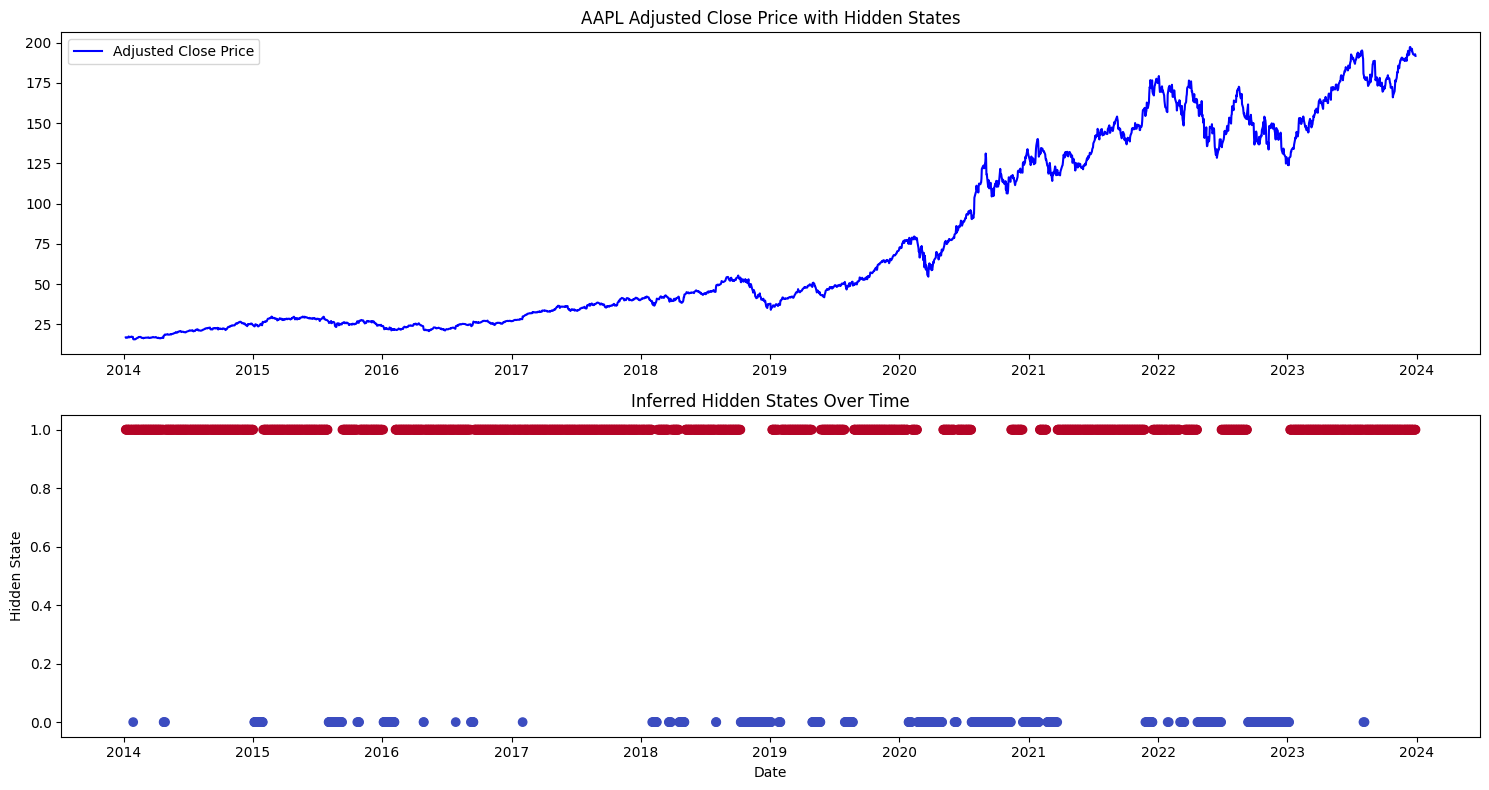

In [14]:
# Visualize the hidden states with the Adjusted Close prices
plt.figure(figsize=(15, 8))

# Plot Adjusted Close prices
plt.subplot(2, 1, 1)
plt.plot(data.index, data['Adj Close'], label='Adjusted Close Price', color='blue')
plt.title(f'{ticker} Adjusted Close Price with Hidden States')
plt.legend()

# Plot the hidden states as a scatter plot (color-coded for each state)
plt.subplot(2, 1, 2)
plt.scatter(data.index, data['Hidden State'], c=hidden_states, cmap='coolwarm', marker='o')
plt.title('Inferred Hidden States Over Time')
plt.ylabel('Hidden State')
plt.xlabel('Date')
plt.tight_layout()
plt.show()


In [15]:
# Print the transition matrix
print("Transition Matrix:")
print(model.transmat_)

# Analyze the transition probabilities
for i in range(n_hidden_states):
    for j in range(n_hidden_states):
        print(f"Probability of transitioning from State {i+1} to State {j+1}: {model.transmat_[i, j]:.4f}")


Transition Matrix:
[[0.90253766 0.09746234]
 [0.03401193 0.96598807]]
Probability of transitioning from State 1 to State 1: 0.9025
Probability of transitioning from State 1 to State 2: 0.0975
Probability of transitioning from State 2 to State 1: 0.0340
Probability of transitioning from State 2 to State 2: 0.9660


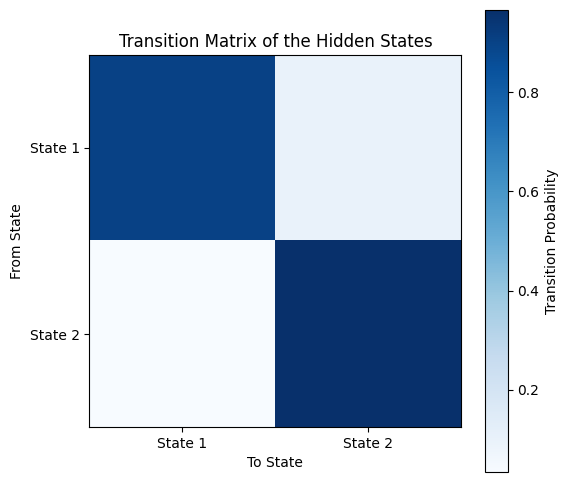

In [16]:
# Plot the transition matrix
plt.figure(figsize=(6, 6))
plt.imshow(model.transmat_, cmap='Blues', interpolation='none')
plt.colorbar(label="Transition Probability")
plt.title("Transition Matrix of the Hidden States")
plt.xlabel("To State")
plt.ylabel("From State")
plt.xticks(np.arange(n_hidden_states), [f'State {i+1}' for i in range(n_hidden_states)])
plt.yticks(np.arange(n_hidden_states), [f'State {i+1}' for i in range(n_hidden_states)])
plt.show()


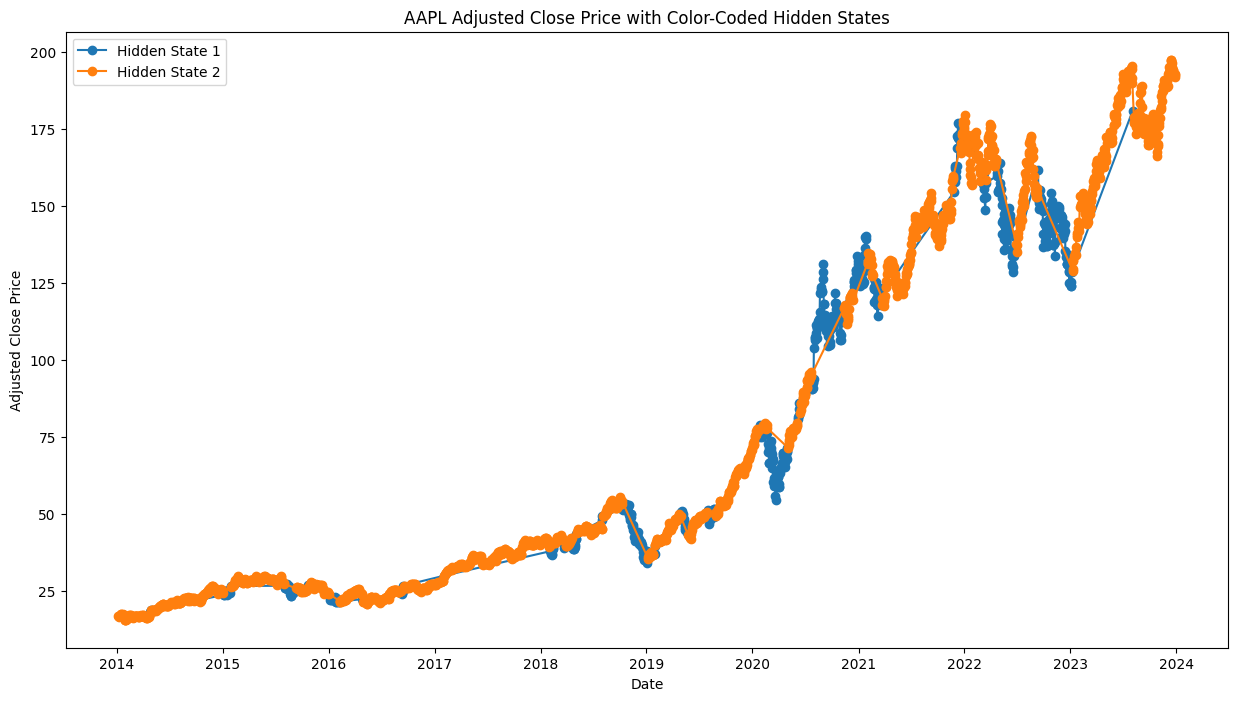

In [17]:
# Plot the Adjusted Close price and color-code by hidden states
plt.figure(figsize=(15, 8))

for state in range(n_hidden_states):
    mask = hidden_states == state
    plt.plot(data.index[mask], data['Adj Close'][mask], linestyle='-', marker='o', label=f'Hidden State {state+1}')

plt.title(f'{ticker} Adjusted Close Price with Color-Coded Hidden States')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()


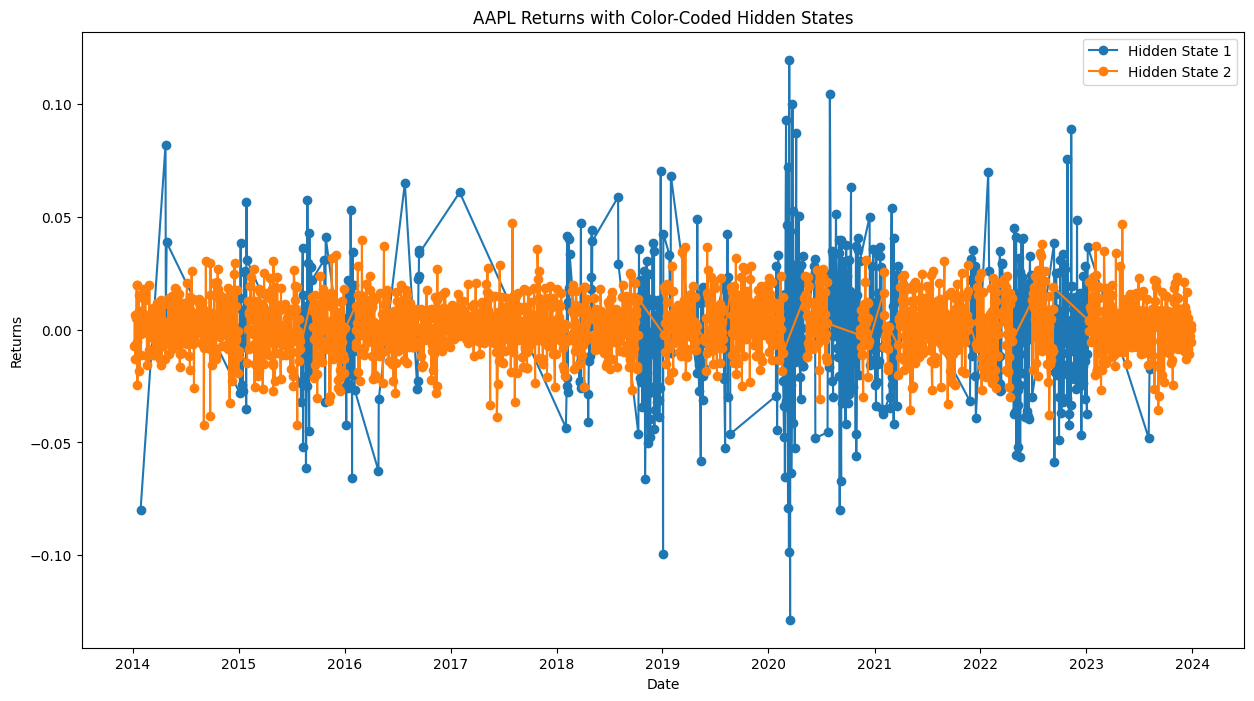

In [18]:
# Plot the returns and color-code by hidden states
plt.figure(figsize=(15, 8))

for state in range(n_hidden_states):
    mask = hidden_states == state
    plt.plot(data.index[mask], data['Returns'][mask], linestyle='-', marker='o', label=f'Hidden State {state+1}')

plt.title(f'{ticker} Returns with Color-Coded Hidden States')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()


In [19]:
# Print the mean and variance of each hidden state
for i in range(n_hidden_states):
    print(f"Hidden State {i+1}:")
    print(f"Mean Return: {model.means_[i][0]}")
    print(f"Variance of Returns: {np.diag(model.covars_[i])[0]}\n")


Hidden State 1:
Mean Return: -0.0003269996911580884
Variance of Returns: 0.0008636246054433049

Hidden State 2:
Mean Return: 0.0016317962162923408
Variance of Returns: 0.00013956890214918073



In [20]:
# Try with 3 hidden states
n_hidden_states_3 = 3

# Fit the HMM with 3 hidden states
model_3 = GaussianHMM(n_components=n_hidden_states_3, covariance_type='full', n_iter=1000).fit(returns)

# Predict the hidden states with 3-state model
hidden_states_3 = model_3.predict(returns)

# Analyze the new model
print("Means and variances for the 3-state HMM:")
for i in range(n_hidden_states_3):
    print(f"\nHidden State {i+1}:")
    print(f"Mean Return = {model_3.means_[i][0]}")
    print(f"Variance of Returns = {np.diag(model_3.covars_[i])[0]}")


Means and variances for the 3-state HMM:

Hidden State 1:
Mean Return = -0.0012787781744518078
Variance of Returns = 0.0008606758380182922

Hidden State 2:
Mean Return = 0.004013299967592846
Variance of Returns = 0.0007622192139789927

Hidden State 3:
Mean Return = 0.0015308054040671774
Variance of Returns = 0.00013060383638209655
